# Complex query

## Query the database using a provenance relationship with the QueryBuilder

Time: 3 mins

##### In this example, we query the calculations in our database that are part of specific groups, and analyze the output. We want to get the magnetization of each structure that we computed. We are also interested in the smearing contribution to the total energy as an indicator of the existence and magnitude of the bandgap.

In [1]:
import sys, numpy as np
from argparse import ArgumentParser
from matplotlib import gridspec, pyplot as plt

from aiida import load_dbenv, is_dbenv_loaded
if not is_dbenv_loaded():
    load_dbenv()
from aiida.orm.querybuilder import QueryBuilder
from aiida.orm.data.structure import StructureData
from aiida.orm.data.parameter import ParameterData
from aiida.orm.calculation.job.quantumespresso.pw import PwCalculation
from aiida.orm.group import Group

In [2]:
def plot_results(query_res):
    """
    :param query_res: The result of an instance of the QueryBuilder
    """
    smearing_unit_set,magnetization_unit_set,pseudo_family_set = set(), set(), set()
    # Storing results:
    results_dict = {}
    for pseudo_family, formula, smearing, smearing_units, mag, mag_units in query_res:
        if formula not in results_dict:
            results_dict[formula] = {}
        # Storing the results:
        results_dict[formula][pseudo_family] = (smearing, mag)
        # Adding to the unit set:
        smearing_unit_set.add(smearing_units)
        magnetization_unit_set.add(mag_units)
        pseudo_family_set.add(pseudo_family)

    # Sorting by formula:
    sorted_results = sorted(results_dict.items())
    formula_list = zip(*sorted_results)[0]
    nr_of_results = len(formula_list)

    # Checks that I have not more than 3 pseudo families.
    # If more are needed, define more colors
    #pseudo_list = list(pseudo_family_set)
    if len(pseudo_family_set) > 3:
        raise Exception('I was expecting 3 or less pseudo families')

    colors = ['b', 'r', 'g']

    # Plotting:
    plt.clf()
    fig=plt.figure(figsize=(16, 9), facecolor='w', edgecolor=None)
    gs  = gridspec.GridSpec(2,1, hspace=0.01, left=0.1, right=0.94)

    # Defining barwidth
    barwidth = 1. / (len(pseudo_family_set)+1)
    offset = [-0.5+(0.5+n)*barwidth for n in range(len(pseudo_family_set))]
    # Axing labels with units:
    yaxis = ("Smearing energy [{}]".format(smearing_unit_set.pop()),
        "Total magnetization [{}]".format(magnetization_unit_set.pop()))
    # If more than one unit was specified, I will exit:
    if smearing_unit_set:
        raise Exception('Found different units for smearing')
    if magnetization_unit_set:
        raise Exception('Found different units for magnetization')
    
    # Making two plots, upper for the smearing, the lower for magnetization
    for index in range(2):
        ax=fig.add_subplot(gs[index])
        for i,pseudo_family in enumerate(pseudo_family_set):
            X = np.arange(nr_of_results)+offset[i]
            Y = np.array([thisres[1][pseudo_family][index] for thisres in sorted_results])
            ax.bar(X, Y,  width=0.2, facecolor=colors[i], edgecolor=colors[i], label=pseudo_family)
        ax.set_ylabel(yaxis[index], fontsize=14, labelpad=15*index+5)
        ax.set_xlim(-0.5, nr_of_results-0.5)
        ax.set_xticks(np.arange(nr_of_results))
        if index == 0:
            plt.setp(ax.get_yticklabels()[0], visible=False)
            ax.xaxis.tick_top()
            ax.legend(loc=3, prop={'size': 18})
        else:
            plt.setp(ax.get_yticklabels()[-1], visible=False)
        for i in range(0, nr_of_results, 2):
            ax.axvspan(i-0.5, i+0.5, facecolor='y', alpha=0.2)
        ax.set_xticklabels(list(formula_list),rotation=90, size=14, ha='center')
    plt.show()

In [3]:
def generate_query_graph(qh, out_file_name):

    def draw_vertice_settings(idx, vertice, **kwargs):
        """
        Returns a string with all infos needed in a .dot file  to define a node of a graph.
        :param node:
        :param kwargs: Additional key-value pairs to be added to the returned string
        :return: a string
        """
        if 'calculation' in vertice['type']:
            shape = "shape=polygon,sides=4"
        elif 'code' in vertice['type']:
            shape = "shape=diamond"
        else:
            shape = "shape=ellipse"
        filters = kwargs.pop('filters', None)
        additional_string = ""
        if filters:
            additional_string += '\nFilters:'
            for k,v in filters.items():
                additional_string += "\n   {} : {}".format(k,v)


        label_string = " ('{}')".format(vertice['tag'])

        labelstring = 'label="{} {}{}"'.format(
            vertice['type'], #.split('.')[-2] or 'Node',
            label_string,
            additional_string)
        #~ return "N{} [{},{}{}];".format(idx, shape, labelstring,
        return "{} [{},{}];".format(vertice['tag'], shape, labelstring)
    nodes = {v['tag']:draw_vertice_settings(idx, v, filters=qh['filters'][v['tag']]) for idx, v in enumerate(qh['path'])}
    links = [(v['tag'], v['joining_value'], v['joining_keyword']) for v in qh['path'][1:]]

    with open('temp.dot','w') as fout:
        fout.write("digraph G {\n")
        for l in links:
            fout.write('    {} -> {} [label=" {}"];\n'.format(*l))
        for _, n_values in nodes.items():
            fout.write("    {}\n".format(n_values))

        fout.write("}\n")
    import os
    os.system('dot temp.dot -Tpng -o {}'.format(out_file_name))

In [4]:
# Each group of calculations that are of interests has the string: "tutorial_"+pseudo,
# where pseudo is lda, pbe or pbesol
group_basename = 'tutorial_%'

#### Start building the query

In [5]:
# Instantiate QB:
qb = QueryBuilder()
# Append the Group to the entities returned, with a filter on the name:
qb.append(Group, filters={'name':{'like':group_basename}}, project='name', tag='group')

#### Visualize the query so far

In [6]:
from IPython.display import Image

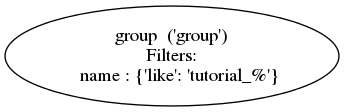

In [7]:
generate_query_graph(qb.get_json_compatible_queryhelp(), 'query1.png')
Image(filename='query1.png')

#### Append the calculations that are members of each group

In [8]:
# I want every PwCalculation that is a member of the specified groups:
qb.append(PwCalculation, tag='calculation', member_of='group')

#### Visualize the current status of the query

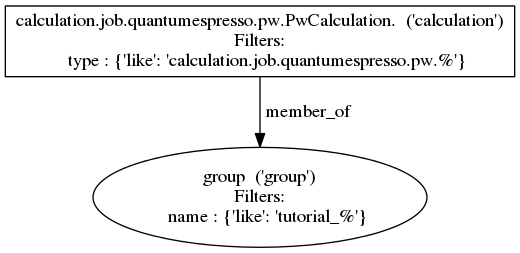

In [9]:
generate_query_graph(qb.get_json_compatible_queryhelp(), 'query2.png') 
Image(filename='query2.png')

#### Append the structures that are input of the calculation. Project the formula, stored in the extras under the key 'formula'

In [10]:
qb.append(StructureData, project=['extras.formula'], tag='structure', input_of='calculation')

#### Visualize the current status of the query

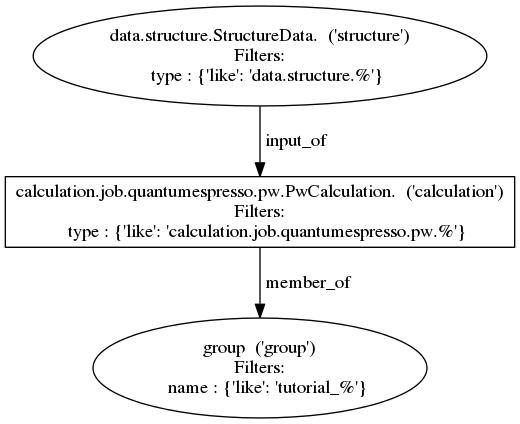

In [11]:
generate_query_graph(qb.get_json_compatible_queryhelp(), 'query3.png')
Image(filename='query3.png')

Append the parameters that are an output of the calculation.

Project:
* The smearing contribution and the units
* The magnetization and the untits.

In [12]:
qb.append(ParameterData,tag='results',
        project=['attributes.energy_smearing', 'attributes.energy_smearing_units',
           'attributes.total_magnetization', 'attributes.total_magnetization_units',
        ], output_of='calculation'
    )

#### Visualize the final query

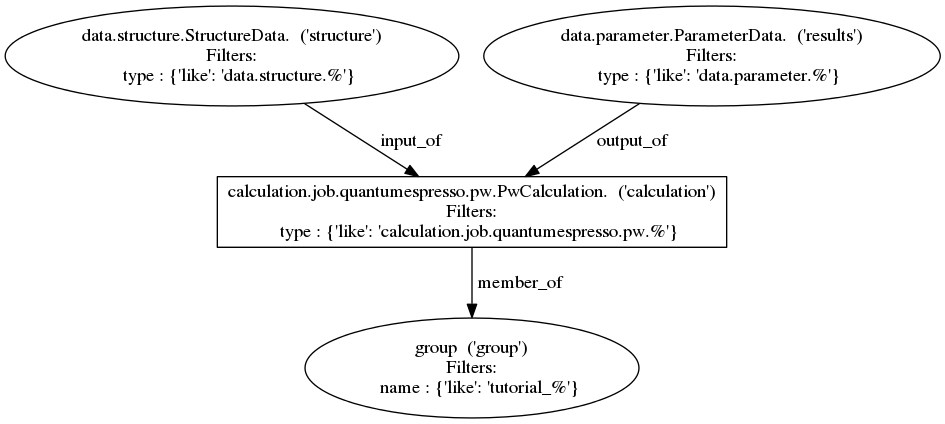

In [13]:
generate_query_graph(qb.get_json_compatible_queryhelp(), 'query4.png') 
Image(filename='query4.png')

#### Print the query results

In [14]:
results = qb.all()
for item in results:
    print ', '.join(map(str, item))

tutorial_pbe, SrHfO3, 0.0, eV, 0.0, Bohrmag / cell
tutorial_pbe, CaZrO3, 0.0, eV, 0.0, Bohrmag / cell
tutorial_pbe, Ge2O3, -0.00109485001313, eV, 0.0, Bohrmag / cell
tutorial_pbe, RbTaO3, 0.0, eV, 0.0, Bohrmag / cell
tutorial_pbe, KTaO3, 0.0, eV, 0.0, Bohrmag / cell
tutorial_pbe, CdSiO3, -0.00092967691559, eV, 0.0, Bohrmag / cell
tutorial_pbe, AgNbO3, -8.84369962145e-06, eV, 0.0, Bohrmag / cell
tutorial_pbe, SrCoO3, -0.141211025392, eV, 2.65, Bohrmag / cell
tutorial_pbe, CsNbO3, -4.23137012657e-05, eV, 0.0, Bohrmag / cell
tutorial_pbe, CaGeO3, -0.0017246574831, eV, 0.0, Bohrmag / cell
tutorial_pbe, BaHfO3, 0.0, eV, 0.0, Bohrmag / cell
tutorial_pbe, KNbO3, -5.44227669012e-06, eV, 0.0, Bohrmag / cell
tutorial_pbe, LaNiO3, -0.0338112323927, eV, 0.0, Bohrmag / cell
tutorial_pbe, PbTiO3, -8.16341503518e-07, eV, 0.0, Bohrmag / cell
tutorial_pbe, GeSiO3, 0.0, eV, 0.0, Bohrmag / cell
tutorial_pbe, AgTaO3, -1.36056917253e-07, eV, 0.0, Bohrmag / cell
tutorial_pbe, BiAlO3, -3.53747984858e-06, eV,

#### Plot the results
Getting a long list is not always helpful. We prepared a function that visualizes the results of the query:

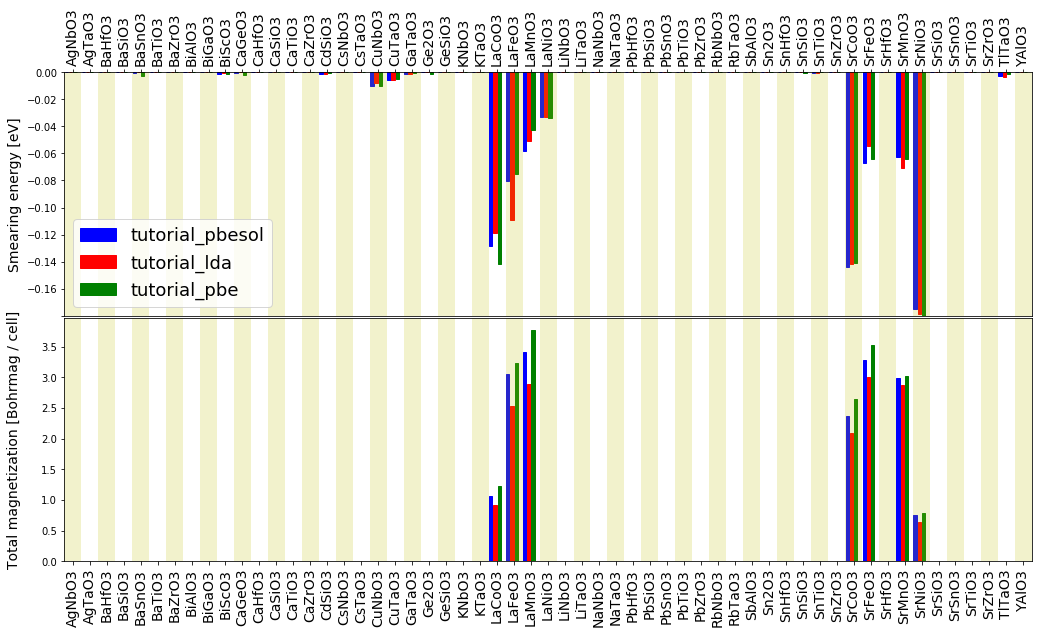

In [15]:
plot_results(results)